In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import mode
from scipy.optimize import curve_fit
from statsmodels.robust import mad
from numpy.random import normal

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

# For the pre-detection of vortices calculations
num_sig = 5.

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

2020 Sep 15 - Some notes about expected detection times, $t_\star / \Gamma$.

Using just the pressure signal, $p = \dfrac{\Delta P}{(1 + (2t/\Gamma)^2)}$,
$\dfrac{t_\star}{\Gamma} \lesssim \frac{1}{2}\sqrt{\dfrac{\Delta P}{n \sigma} - 1} \approx 1$.

Using the derivative, $\dfrac{dp}{dt} = -\dfrac{\Delta P}{\left(1 + \left( 2 t/\Gamma \right)^2\right)^2}2 \left( 2 t/\Gamma \right)\dfrac{2}{\Gamma} \approx -\left( \dfrac{4\Delta P}{\Gamma} \right) \left( \dfrac{2 t}{\Gamma} \right)$, $\left( \dfrac{t_\star}{\Gamma} \right) \approx \frac{1}{4} \left( \dfrac{n \sigma}{\Delta P} \right) \left( \dfrac{\Gamma}{\Delta t} \right) \approx 0.4$, with $\Delta t$ the time sampling.

1.7049903912934776
70.9581
0.028771190063738333
0.5771144278606966
0.31343283582089554
10.277495502670932 4.79195 1.6 248.6


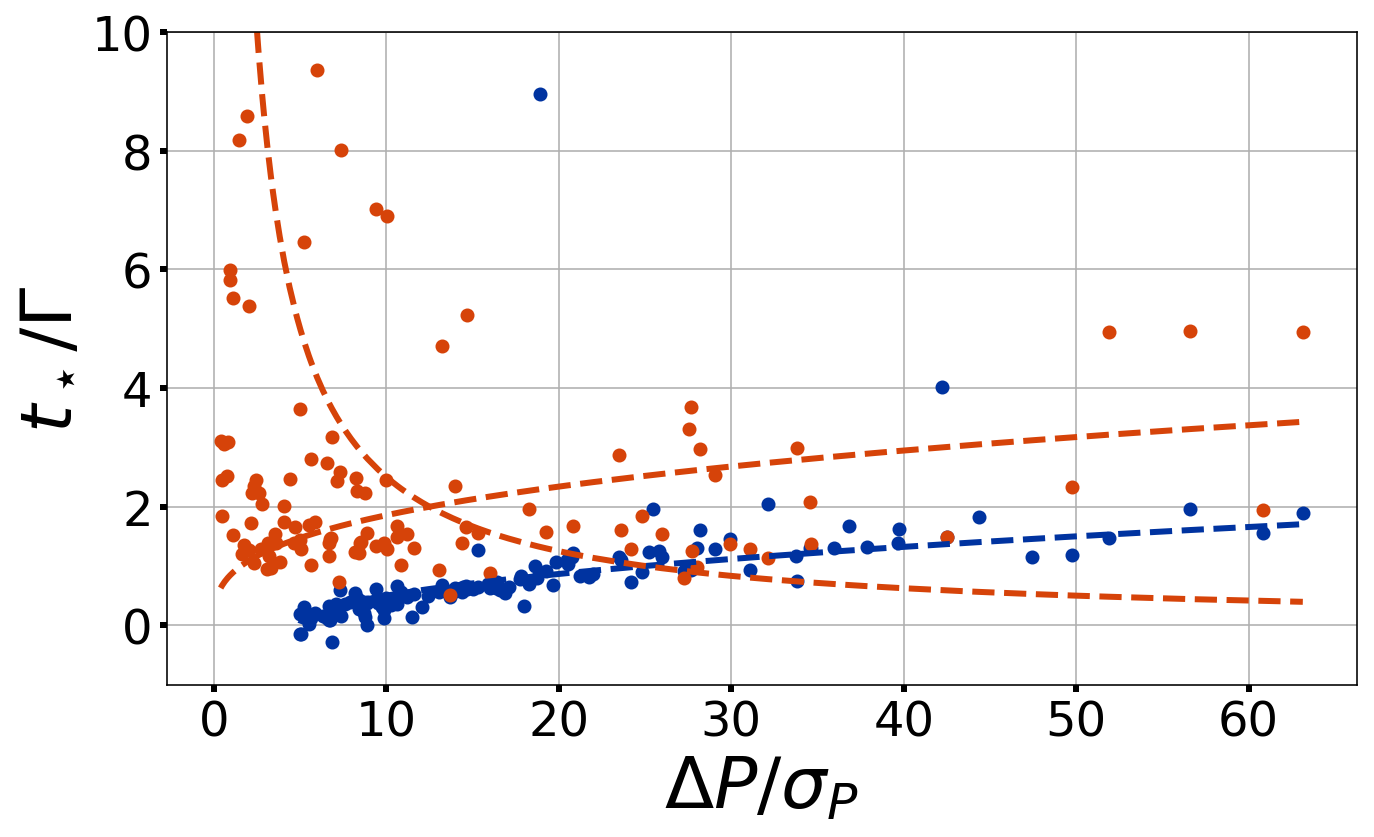

In [5]:
filename = "anticipating_encounters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Gamma', 'pressure_scatter', 'dpdt_scatter', 
# 'pressure_outlier_time', 'dpdt_outlier_time')

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# Check how likely detection is to be real
# for i in range(len(data['DeltaP'])):
# for i in range(len()):
#     expected_p_outlier_time = 0.5*np.sqrt(data['DeltaP'][i]/num_sig/data['pressure_scatter'][i] - 1.)
#     expected_dpdt_outlier_time = 0.5*np.power(4.*data['DeltaP'][i]/num_sig/data['pressure_scatter'][i]*\
#                                               (sampling*3600./data['Gamma'][i]), 1./3)
#     print(-data['pressure_outlier_time'][i]/data['Gamma'][i], expected_p_outlier_time)
#     print(-data['dpdt_outlier_time'][i]/data['Gamma'][i], expected_dpdt_outlier_time)

sampling = 1. # 1 second sampling

expected_p_outlier_time = 0.5*np.sqrt(data['DeltaP']/num_sig/data['pressure_scatter'] - 1.)
print(np.nanmax(expected_p_outlier_time))
expected_dpdt_outlier_time = 0.25*num_sig*data['pressure_scatter']/data['DeltaP']*data['Gamma']/(sampling*3600.)
print(np.max(data['Gamma']))
print(np.nanmax(expected_dpdt_outlier_time))
# mx_outlier_time = np.max([np.nanmax(expected_p_outlier_time), np.nanmax(expected_dpdt_outlier_time)])
mx_outlier_time = 2.

ax.plot(data['DeltaP']/data['pressure_scatter'], -data['pressure_outlier_time']/data['Gamma'], 
        marker='o', ls='', color=BoiseState_blue)
ax.plot(data['DeltaP']/data['pressure_scatter'], -data['dpdt_outlier_time']/data['Gamma'], 
        marker='o', ls='', color=BoiseState_orange)
# ax.axhline(mx_outlier_time, color='black', lw=3, ls='--')
# Expected scaling

x = data['DeltaP']/data['pressure_scatter']
y = -data['pressure_outlier_time']/data['Gamma']
g = data['Gamma']
y = y[np.argsort(x)]
g = g[np.argsort(x)]
x = x[np.argsort(x)]
num_good_times = len(y[(y > 0) & (y < mx_outlier_time)])
num_bad_times = len(y[(y < 0) | (y > mx_outlier_time) | (np.isnan(y))])
# print(num_good_times)
# print(num_bad_times)
print(num_good_times/(num_good_times + num_bad_times))

ax.plot(x, 0.5*np.sqrt(x/num_sig - 1.), lw=3, ls='--', color=BoiseState_blue)

factor = 0.25*num_sig/x*(10./(sampling))
ax.plot(x, 2*factor, lw=3, ls='--', color=BoiseState_orange)

ax.plot(x, 2.*np.power(1/factor, 1./3), lw=3, ls='--', color=BoiseState_orange)
# ax.plot(x, 0.25*(num_sig/x)*(10./(sampling*3600.)), lw=3, ls='--', color=BoiseState_orange)

y = -data['dpdt_outlier_time']/data['Gamma']
num_good_times = len(y[(y > 0) & (y < mx_outlier_time)])
num_bad_times = len(y[(y < 0) | (y > mx_outlier_time) | (np.isnan(y))])
# print(num_good_times)
# print(num_bad_times)
print(num_good_times/(num_good_times + num_bad_times))

ax.grid(True)
# ax.set_xlim([3, 70.])
ax.set_ylim([-1., 10.])
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$\Delta P/\sigma_{P}$', fontsize=36)
ax.set_ylabel(r'$t_\star/\Gamma$', fontsize=36)

ind = np.argmin(np.abs(data['DeltaP'] - np.median(data['DeltaP'])))
print(data['DeltaP'][ind]/data['pressure_scatter'][ind], data['Gamma'][ind], 
      -data['pressure_outlier_time'][ind], -data['dpdt_outlier_time'][ind])

# fig.savefig("../figures/tstar_vs_DeltaP-sigma.png", dpi=500, bbox_inches="tight")

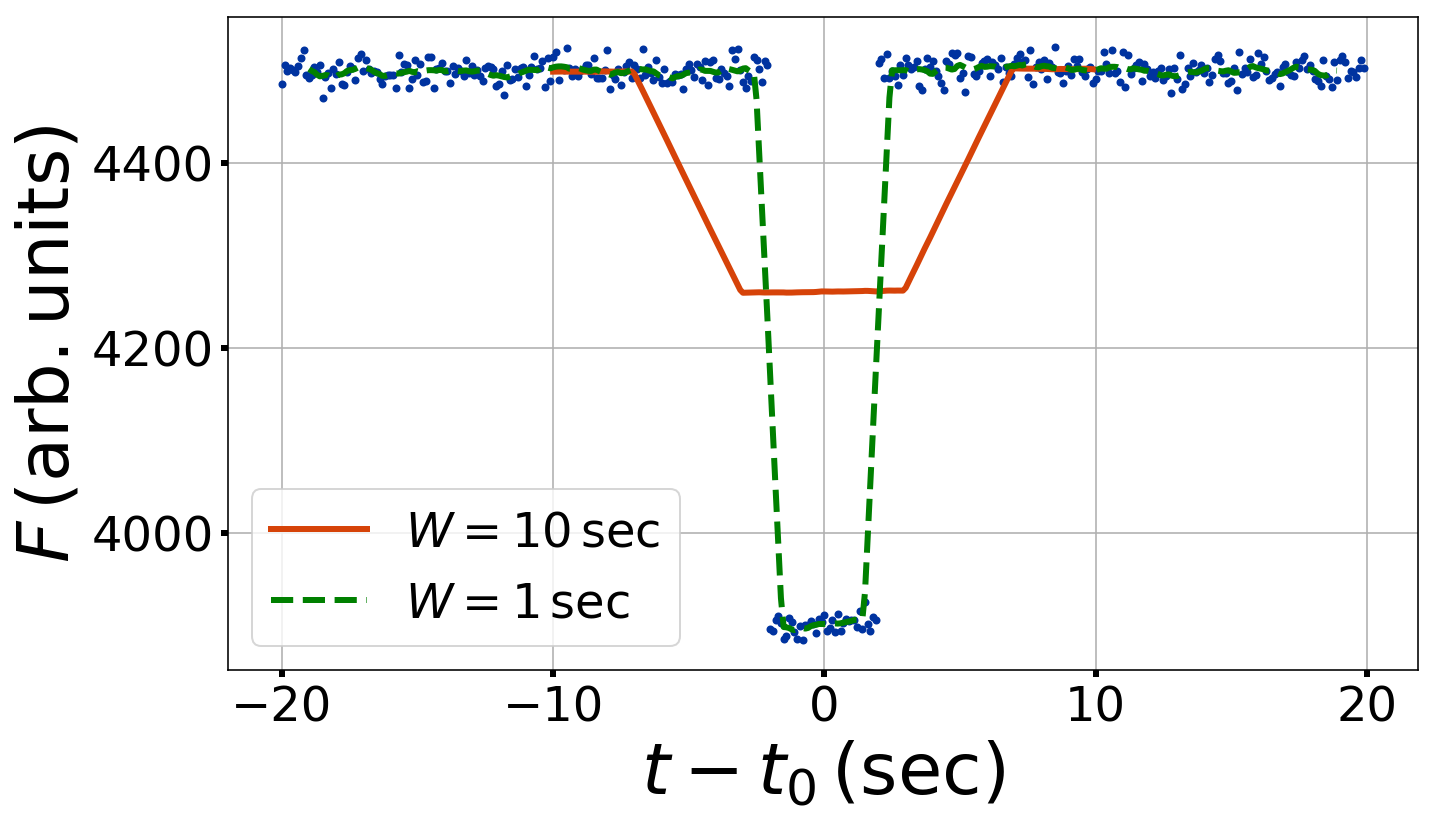

In [6]:
from astropy.convolution import convolve, Box1DKernel

def simple_flux_profile(t, t0, Dact, U, F0, DeltaF):
    ret_val = np.ones_like(t)*F0
    
    ind = np.abs(t - t0) <= Dact/U
    if(len(t[ind]) > 0):
        ret_val[ind] = F0 - DeltaF

    return ret_val

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# 2020 Sep 16 - Example solar flux measurement
t0 = 0.
Dact = 10. # m
U = 5. # m/s
F0 = 4500.
DeltaF = 600.
sigma_F = 10.

high_res_sampling = 0.1

t = np.arange(-10.*Dact/U, 10.*Dact/U, high_res_sampling)
prof = simple_flux_profile(t, t0, Dact, U, F0, DeltaF) + normal(scale=sigma_F, size=len(t))
ax.plot(t, prof, marker='.', color=BoiseState_blue, ls='')

# Too low-res
low_res_sampling = 10.
num_points = int(low_res_sampling/high_res_sampling)
observed_prof = convolve(prof, Box1DKernel(num_points))
ind = (t - np.min(t) > low_res_sampling) & (np.max(t) - t > low_res_sampling)
ax.plot(t[ind], observed_prof[ind], color=BoiseState_orange, lw=3, label=r'$W = 10\,{\rm sec}$')

# Better resolution
low_res_sampling = 1.
num_points = int(low_res_sampling/high_res_sampling)
observed_prof = convolve(prof, Box1DKernel(num_points))
ind = (t - np.min(t) > low_res_sampling) & (np.max(t) - t > low_res_sampling)
ax.plot(t[ind], observed_prof[ind], color='green', lw=3, ls='--', label=r'$W = 1\,{\rm sec}$')

# predicted_Fstar = F0 - np.min([2.*(Dact/U)/low_res_sampling, 1.])*DeltaF
# plt.axhline(predicted_Fstar)

ax.grid(True)
ax.legend(loc='best', fontsize=24)
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$t - t_0\,\left( {\rm sec} \right)$', fontsize=36)
ax.set_ylabel(r'$F\,\left( {\rm arb. units} \right)$', fontsize=36)

# fig.savefig("../figures/flux_sampling.png", dpi=500, bbox_inches="tight")

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
sols = data['sol'][ind]
t0 = data['t0'][ind]
vortex_number = data['vortex_number'][ind]
Gamma = data['Gamma'][ind]
DeltaP = data['DeltaP'][ind]
slope = data['slope'][ind]
intercept = data['intercept'][ind]

2020 Sep 16 - Wind profile

With a wind profile $V(t)/V_{\rm act} = \dfrac{|t^\prime|}{1 + {t^\prime}^2}$, the maximum in the profile $V_\star$ observed when the sampling interval is $W$ is given by

$$
V_\star/V_{\rm act} = \left( \dfrac{D}{UW} \right) \int_{1 - \frac{UW}{2D}}^{1 + \frac{UW}{2D}} \dfrac{|t^\prime|}{1 + {t^\prime}^2} dt^\prime = \frac{1}{2} \left( \dfrac{D}{UW} \right) \ln \left[ \dfrac{\left( 1 + \frac{UW}{2D} \right)^2 + 1}{\left( 1 - \frac{UW}{2D} \right)^2 + 1} \right].
$$

1.4160000000000001


(0, 10)

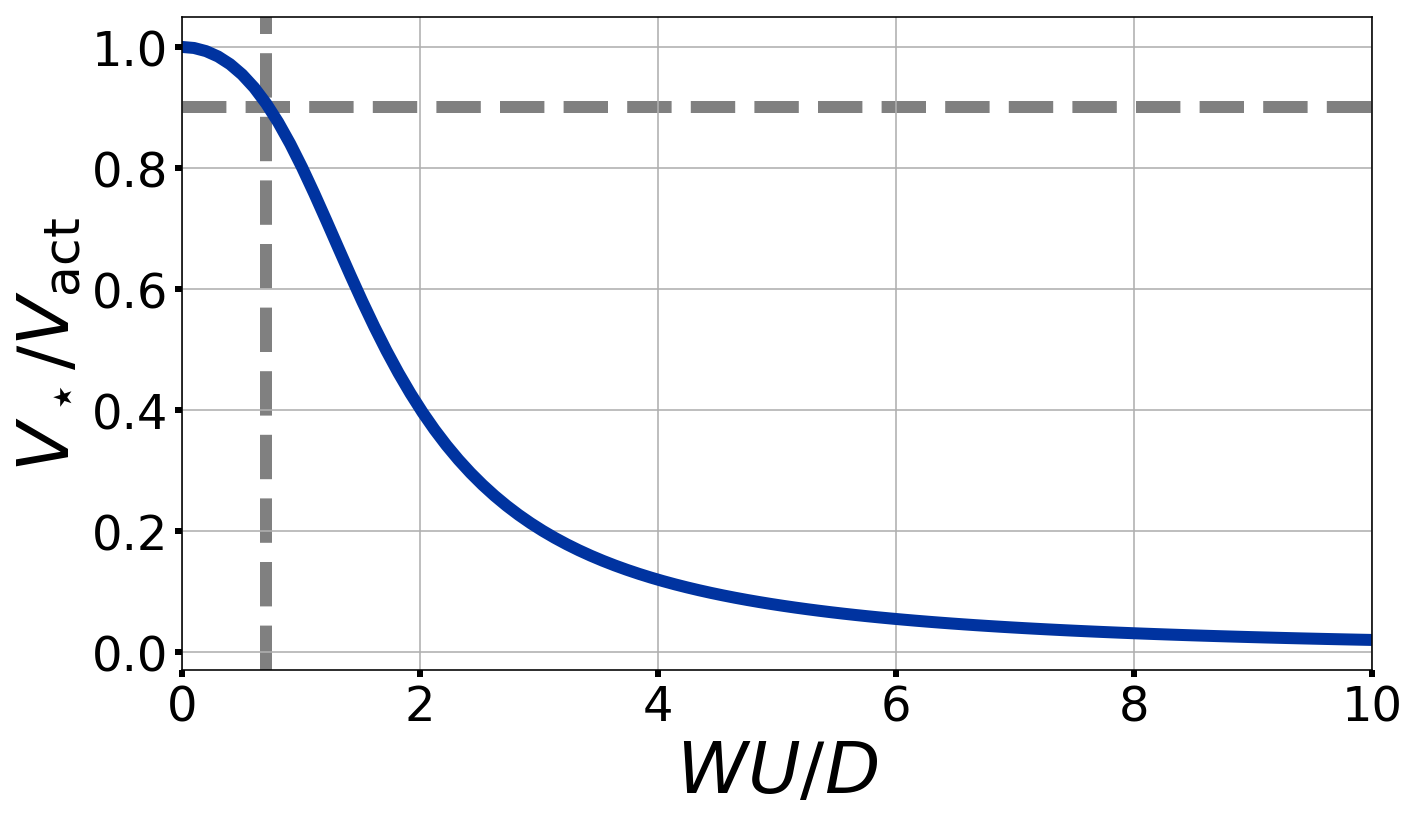

In [7]:
def Vstar_Vact(x):
    return 0.5/x*np.log(((1 + x)**2 + 1)/((1 - x)**2 + 1))

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

x = np.linspace(0.001, 10., 100)
ax.plot(x, Vstar_Vact(x), lw=6, color=BoiseState_blue)

Dact = 10.
U = 5.
desired_accuracy = 0.9

ind = np.argmin(np.abs(Vstar_Vact(x) - desired_accuracy))
print(x[ind]*Dact/U)

ax.axvline(x[ind], color='grey', lw=6, ls='--', zorder=-1)
ax.axhline(desired_accuracy, color='grey', lw=6, ls='--', zorder=-1)

ax.grid(True)
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$W U / D$', fontsize=36)
ax.set_ylabel(r'$V_\star/ V_{\rm act}$', fontsize=36)
ax.set_xlim([0, 10])

# fig.savefig("../figures/sampled_wind_profile.png", dpi=500, bbox_inches="tight")
# fig.savefig("../figures/sampled_wind_profile_with_lines.png", dpi=500, bbox_inches="tight")